In [1]:
# Set the number of number of OMP threads to 1
%env OMP_NUM_THREADS=1

# Update path including qFlex root
import sys, os
sys.path.insert(1, os.path.dirname('./../'))

from typing import List
from python.circuits import generator
from multiprocessing import Pool
import matplotlib.pyplot as plt
from python import qflex
from tqdm import tqdm
import numpy as np
import cirq

env: OMP_NUM_THREADS=1


## Define the IBM Rochester Layout

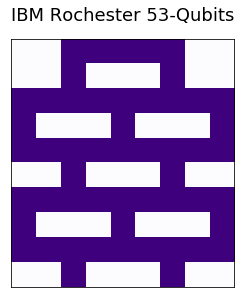

In [2]:
ibm_rochester = """001111100
001000100
111111111
100010001
111111111
001000100
111111111
100010001
111111111
001000100""".split('\n')

# Get qubits map
qubits_map = {}
for x,k in enumerate(int(y) for x in ibm_rochester for y in x):
    if k != 0:
        qubits_map[len(qubits_map)] = x

plt.matshow([[int(x) for x in line] for line in ibm_rochester], cmap='Purples')
plt.xticks([])
plt.yticks([])
plt.title('IBM Rochester 53-Qubits', fontsize=18)
plt.show()

## Specify the Ordering of the Contraction

In [3]:
ibm_rochester_ordering = """
# NO INITIAL CUTS
#
# EXPAND PATCH p74
expand p74 83
expand p74 74
#
# EXPAND PATCH p78
expand p78 87
expand p78 78
#
# EXPAND PATCH A
expand A 75
merge p74 A
#
# EXPAND PATCH B
expand B 77
merge p78 B
#
# EXPAND PATCH C
expand C 55
expand C 54
expand C 63
expand C 72
expand C 73
# MERGE C A
merge C A
# EXPAND PATCH D
expand D 67
expand D 76
# EXPAND PATCH E
expand E 61
expand E 62
expand E 71
expand E 80
expand E 79
# MERGE E B
merge E B
#
# EXPAND PATCH F
expand F 57
expand F 56
expand F 47
# EXPAND PATCH G
expand G 59
expand G 58
# EXPAND PATCH H
expand H 51
expand H 60
#
# EXPAND PATCH I
expand I 19
expand I 18
expand I 27
expand I 36
expand I 37
expand I 38
expand I 39
# EXPAND PATCH J
expand J 31
expand J 40
# EXPAND PATCH K
expand K 25
expand K 26
expand K 35
expand K 44
expand K 43
expand K 42
expand K 41
#
# EXPAND PATCH L
expand L 20
# EXPAND PATCH M
expand M 21
expand M 22
expand M 23
# EXPAND PATCH N
expand N 24
#
# MERGE PATCHES
merge A D
merge B H
merge G F
merge D F
merge H F
merge F I
merge J I
merge K I
merge M L
merge I L
merge N L
#
# BEGIN TERMINAL CUTS
cut (0) 2
cut (0) 3
cut (0) 4
cut (0) 5
cut (0) 6
cut (0) 11
cut (0) 15
#
# EXPAND PATCH O
expand O 11
expand O 2
expand O 3
expand O 4
expand O 5
expand O 6
expand O 15
#
# MERGE PATCHES L O
merge L O
"""

## Specify the Layout for Random Quantum Circuits

As for the Quantum Supremacy experiments in `Nature 574 (7779), 505-510`, we need to specify a pattern for the random quantum circuits to benchmark the IBM Rochester. In particular, we have maximized the number of parallel gates per cycle and we have made sure that every qubits interact with every neighbor every 3 cycles.

In [4]:
# Define pattern for the generation of RQCs
ibm_rochester_pattern = {
    'A': {(0, 1), (2, 3), (4, 6), (5, 9), (7, 8), (10, 11), (12, 13),
          (14, 15), (16, 19), (18, 27), (20, 21), (23, 24), (25, 26),
          (28, 32), (30, 31), (33, 34), (36, 37), (38, 41), (39, 42),
          (43, 44), (45, 46), (47, 48), (49, 50)},
    'B': {(0, 5), (1, 2), (3, 4), (6, 13), (7, 16), (9, 10), (11, 12),
          (15, 18), (17, 23), (19, 20), (21, 22), (24, 25), (26, 27),
          (29, 36), (30, 39), (32, 33), (34, 35), (37, 38), (40, 46),
          (41, 50), (42, 43), (44, 45), (48, 49)},
    'C': {(0, 5), (1, 2), (3, 4), (7, 16), (8, 9), (11, 17), (13, 14),
          (15, 18), (19, 20), (21, 28), (22, 23), (25, 29), (26, 27),
          (30, 39), (31, 32), (34, 40), (35, 36), (37, 38), (41, 50),
          (42, 43), (44, 51), (46, 47), (48, 52)},
}

# Define the sequence of patterns
ibm_rochester_sequence = "ABC"

# Define IBM Rochester gates
ibm_rochester_1q_gates = ["x_1_2", "y_1_2", "t"]
ibm_rochester_2q_gate = "cx"

In [5]:
# Get a generator of RQCs
prqcg = generator.PseudoRandomCircuitGenerator(
            generator.Device(ibm_rochester_pattern),
            ibm_rochester_1q_gates, 
            ibm_rochester_2q_gate)

def get_rqc(depth: int, seed: int = None):
  
    # Get seed if none provided
    if seed == None:
        seed = np.random.randint(2**63)

    # Get a RQC ...
    rqc = prqcg.generate(ibm_rochester_sequence, depth, seed)
  
    # ... and remap them accordingly to layout
    rqc = [' '.join([str(int(x[0])+1)]+[x[1]]+[str(qubits_map[int(y)]) for y in x[2:]]) 
            for x in (x.split() for x in rqc.to_qsim_lines())]
  
    # Add layer of hadamard at the beginning and end
    rqc = ['0 h ' + str(qubits_map[q]) for q in range(len(qubits_map))] + rqc
    rqc = rqc + [str(int(rqc[-1].split()[0])+1) + ' h ' + str(qubits_map[q]) for q in range(len(qubits_map))]
  
    # Add number of qubits at the beginning
    rqc.insert(0, str(len(qubits_map)))
  
    return rqc

## Simulate the Random Quantum Circits

In [6]:
def get_bitstring(size: int):
  
    bitstrings = {bin(np.random.randint(2**len(qubits_map)))[2:].zfill(len(qubits_map)) 
                             for _ in range(size)}
    
    while len(bitstrings) != size:
        bitstrings.add(bin(np.random.randint(2**len(qubits_map)))[2:].zfill(len(qubits_map)) 
                for _ in range(size - len(bitstrings)))
        
    return list(bitstrings)

In [12]:
# Get a random quantum circuits for a given depth
ibm_rochester_depth = 12
ibm_rochester_rqc = get_rqc(ibm_rochester_depth)

# Get a list of final bitstrings
final_bitstrings = get_bitstring(10000)

In [13]:
# Simulate the circuit using qFlex
def run_simulation(final_bitstring: str):

    options = {
      'circuit': ibm_rochester_rqc,
      'ordering': ibm_rochester_ordering.split('\n'),
      'grid': ibm_rochester,
      'final_state' : final_bitstring
    }
  
    return qflex.simulate(options)

results = []
with Pool(8) as pool:
    for bs in tqdm(np.array_split(final_bitstrings, int(len(final_bitstrings)/32))):
        results.extend(pool.map(run_simulation, bs))

  7%|▋         | 22/312 [00:08<01:49,  2.65it/s]Process ForkPoolWorker-29:
Traceback (most recent call last):



KeyboardInterrupt: 

[array(['00010010111111011110100010011000100000000111101100001',
        '11110100010110001100110110100110000000111001100010110',
        '01010001010000111011111010110011010001001110000110010',
        '11100110001101110000111110110010111001110011010010111',
        '00010100101110011111001001100011011111101111010011101',
        '10001101011010011110101100001001000011001101101111111',
        '10111111010101011010110011010010010000000101010100011',
        '11001001110111011011010100101010000111111111000100000',
        '00001100011111111000100111010001010000110111100110101',
        '10010001011101100100111101010110011101011101100101100',
        '11001011100110100110010000010100111000010100111100001',
        '11100100111000010110111111110000000111010000001010100',
        '10110101000000100010110101001000001000010001110011101',
        '11001101110010001110111011010010001000000101000010110',
        '00111111000111110111100100100000110000000111110110011',
        '1111011011011111

In [77]:
# Simulate the circuit using qFlex
def run_simulation(rqc: List[str], final_bitstring: str):

    options = {
      'circuit': rqc,
      'ordering': ibm_rochester_ordering.split('\n'),
      'grid': ibm_rochester,
      'final_state' : final_bitstring
    }
  
    return qflex.simulate(options)

In [71]:
run_simulation(ibm_rochester_rqc, final_bitstring[0])

[('00000000111101000111101001011001001110110111001101001',
  (1.6656039047990845e-10-5.649085643710805e-10j))]

In [67]:
ibm_rochester_ordering.split('\n')

['',
 '# NO INITIAL CUTS',
 '#',
 '# EXPAND PATCH p74',
 'expand p74 83',
 'expand p74 74',
 '#',
 '# EXPAND PATCH p78',
 'expand p78 87',
 'expand p78 78',
 '#',
 '# EXPAND PATCH A',
 'expand A 75',
 'merge p74 A',
 '#',
 '# EXPAND PATCH B',
 'expand B 77',
 'merge p78 B',
 '#',
 '# EXPAND PATCH C',
 'expand C 55',
 'expand C 54',
 'expand C 63',
 'expand C 72',
 'expand C 73',
 '# MERGE C A',
 'merge C A',
 '# EXPAND PATCH D',
 'expand D 67',
 'expand D 76',
 '# EXPAND PATCH E',
 'expand E 61',
 'expand E 62',
 'expand E 71',
 'expand E 80',
 'expand E 79',
 '# MERGE E B',
 'merge E B',
 '#',
 '# EXPAND PATCH F',
 'expand F 57',
 'expand F 56',
 'expand F 47',
 '# EXPAND PATCH G',
 'expand G 59',
 'expand G 58',
 '# EXPAND PATCH H',
 'expand H 51',
 'expand H 60',
 '#',
 '# EXPAND PATCH I',
 'expand I 19',
 'expand I 18',
 'expand I 27',
 'expand I 36',
 'expand I 37',
 'expand I 38',
 'expand I 39',
 '# EXPAND PATCH J',
 'expand J 31',
 'expand J 40',
 '# EXPAND PATCH K',
 'expand K

In [72]:
type(ibm_rochester_rqc)

list

In [76]:
ibm_rochester_rqc

['53',
 '0 h 2',
 '0 h 3',
 '0 h 4',
 '0 h 5',
 '0 h 6',
 '0 h 11',
 '0 h 15',
 '0 h 18',
 '0 h 19',
 '0 h 20',
 '0 h 21',
 '0 h 22',
 '0 h 23',
 '0 h 24',
 '0 h 25',
 '0 h 26',
 '0 h 27',
 '0 h 31',
 '0 h 35',
 '0 h 36',
 '0 h 37',
 '0 h 38',
 '0 h 39',
 '0 h 40',
 '0 h 41',
 '0 h 42',
 '0 h 43',
 '0 h 44',
 '0 h 47',
 '0 h 51',
 '0 h 54',
 '0 h 55',
 '0 h 56',
 '0 h 57',
 '0 h 58',
 '0 h 59',
 '0 h 60',
 '0 h 61',
 '0 h 62',
 '0 h 63',
 '0 h 67',
 '0 h 71',
 '0 h 72',
 '0 h 73',
 '0 h 74',
 '0 h 75',
 '0 h 76',
 '0 h 77',
 '0 h 78',
 '0 h 79',
 '0 h 80',
 '0 h 83',
 '0 h 87',
 '1 t 2',
 '1 t 3',
 '1 x_1_2 4',
 '1 x_1_2 5',
 '1 t 6',
 '1 y_1_2 11',
 '1 y_1_2 15',
 '1 x_1_2 18',
 '1 x_1_2 19',
 '1 t 20',
 '1 t 21',
 '1 t 22',
 '1 y_1_2 23',
 '1 t 24',
 '1 x_1_2 25',
 '1 x_1_2 26',
 '1 t 27',
 '1 x_1_2 31',
 '1 t 35',
 '1 y_1_2 36',
 '1 t 37',
 '1 x_1_2 38',
 '1 t 39',
 '1 x_1_2 40',
 '1 x_1_2 41',
 '1 x_1_2 42',
 '1 y_1_2 43',
 '1 t 44',
 '1 y_1_2 47',
 '1 x_1_2 51',
 '1 t 54',
 '1 t 5

In [63]:
final_bitstring

['10110110111101000111101001011001001110110111001101001',
 '01001010011101011010000101110100110011110101110011110',
 '01101110110110011111110000110010011011001001011110110',
 '00110101111100001010001111101111000110001011001011001',
 '01111110011111001101011100100101010110101000110100110',
 '11010101100100111011011101001101110110011100010110000',
 '01101110011001101010001000011111011110001110101101100',
 '11110000101000010101000111100001110101101000001011000',
 '00011011111001111010000111000111110110111111000111000',
 '01111101110100010011110010101111010110111101000101000',
 '11001111101100000110011001101010001110110100000110101',
 '10101011111010011110001011010010100100001111100001001',
 '00011010100010001100101110101000101100110111010010010',
 '11110110101111001110001011001100011101111111000010110',
 '01101111001101110001100101010010000100010101010111101',
 '00010000110000100110010001101111101111100100110111001',
 '00111111001101100111111000000110111001011000010110000',
 '011101011110

In [1]:
# Set the number of number of OMP threads to 1
%env OMP_NUM_THREADS=1

# Update path including qFlex root
import sys, os
sys.path.insert(1, os.path.dirname('./../'))

from python import qflex
from python import utils
from python.ordering import order_circuit_simulation as order_lib
from python.circuits import generator
from progressbar import progressbar as pb
from io import StringIO
from multiprocessing import Pool
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import cirq

env: OMP_NUM_THREADS=1


In [ ]:
p

In [2]:
# Get ordering
def get_ordering(grid, circuit):
    qubits = utils.GetGridQubits(StringIO('\n'.join(grid)))
    circuit = utils.GetCircuit(StringIO('\n'.join(circuit)), qubits)
    return order_lib.circuit_to_ordering(circuit, qubit_names=sorted(qubits))

In [3]:
# Define IBM Rochester layout
ibm_rochester = """001111100
001000100
111111111
100010001
111111111
001000100
111111111
100010001
111111111
001000100""".split('\n')

In [4]:
# Define IBM Rochester gates
ibm_rochester_1q_gates = ["x_1_2", "y_1_2", "t"]
ibm_rochester_2q_gate = "cx"

In [10]:
# Define pattern for the generation of RQCs
ibm_rochester_pattern = {
    'A': {(0, 1), (2, 3), (4, 6), (5, 9), (7, 8), (10, 11), (12, 13),
          (14, 15), (16, 19), (18, 27), (20, 21), (23, 24), (25, 26),
          (28, 32), (30, 31), (33, 34), (36, 37), (38, 41), (39, 42),
          (43, 44), (45, 46), (47, 48), (49, 50)},
    'B': {(0, 5), (1, 2), (3, 4), (6, 13), (7, 16), (9, 10), (11, 12),
          (15, 18), (17, 23), (19, 20), (21, 22), (24, 25), (26, 27),
          (29, 36), (30, 39), (32, 33), (34, 35), (37, 38), (40, 46),
          (41, 50), (42, 43), (44, 45), (48, 49)},
    'C': {(0, 5), (1, 2), (3, 4), (7, 16), (8, 9), (11, 17), (13, 14),
          (15, 18), (19, 20), (21, 28), (22, 23), (25, 29), (26, 27),
          (30, 39), (31, 32), (34, 40), (35, 36), (37, 38), (41, 50),
          (42, 43), (44, 51), (46, 47), (48, 52)},
}

# Define the sequence of patterns
ibm_rochester_sequence = "ABC"

# Define the depth of the circuit
ibm_rochester_depth = 20

# Get qubits map
qubits_map = {}
for x,k in enumerate(int(y) for x in ibm_rochester for y in x):
    if k != 0:
        qubits_map[len(qubits_map)] = x

In [11]:
# Get a generator of RQCs
prqcg = generator.PseudoRandomCircuitGenerator(
            generator.Device(ibm_rochester_pattern),
            ibm_rochester_1q_gates, 
            ibm_rochester_2q_gate)

def get_rqc():

    # Get a RQC ...
    rqc = prqcg.generate(ibm_rochester_sequence, ibm_rochester_depth, 123)
  
    # ... and remap them accordingly to layout
    rqc = [' '.join([str(int(x[0])+1)]+[x[1]]+[str(qubits_map[int(y)]) for y in x[2:]]) 
            for x in (x.split() for x in rqc.to_qsim_lines())]
  
    # Add layer of hadamard at the beginning and end
    rqc = ['0 h ' + str(qubits_map[q]) for q in range(len(qubits_map))] + rqc
    rqc = rqc + [str(int(rqc[-1].split()[0])+1) + ' h ' + str(qubits_map[q]) for q in range(len(qubits_map))]
  
    # Add number of qubits at the beginning
    rqc.insert(0, str(len(qubits_map)))
  
    return rqc

In [12]:
# Get ordering
ordering = get_ordering(ibm_rochester, [x for x in get_rqc() if len(x.split()) == 4])

KeyboardInterrupt: 

In [8]:
# Simulate the circuit using qFlex
def run_simulation(final_state):

    options = {
      'circuit': get_rqc(),
      'ordering': ordering,
      'grid': ibm_rochester,
      'final_state' : final_state
    }
  
    return qflex.simulate(options)

with Pool(8) as pool:
    results = []
    for _ in pb(range(10)):
        results.extend(pool.map(run_simulation, [bin(np.random.randint(2**len(qubits_map)))[2:].zfill(len(qubits_map)) for _ in range(32)]))

100% (10 of 10) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


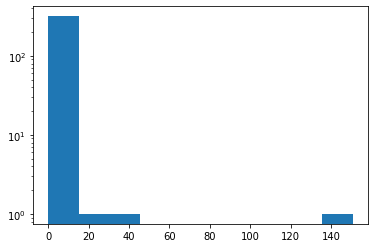

In [9]:
N = 2 ** (len(qubits_map))
plt.hist([N * np.abs(x[0][1])**2 for x in results])
plt.yscale('log')
plt.show()